# Objective: To assign patients beds effectively to minimize the waiting time

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Steps:
1. Split the State in 2 parts S_in and S_out depending upon the threshold (U). 
2. S_in = data[<=U], S_out = data[>U] 
3. Initialize Lyapunov function
4. Baseline model
5. Exploration: Initiate model and estimate Lyapunov function 
6. Exploitation: Policy from Exploration will be used for S_in and for S_out a stable policy will be used.
7. Estimate model stability using Lyapunov function 

# Dummy dataset with some main features

In [3]:
# Generating random datetime values within a certain range
from datetime import datetime, timedelta
import random

N_obs = 2000


start_datetime = datetime(2023, 1, 1, 0, 0, 0)
end_datetime = datetime(2023, 1, 10, 23, 59, 59)


random_date_times = [
    start_datetime + timedelta(
        seconds=random.randint(0, int((end_datetime - start_datetime).total_seconds()))
    )
    for _ in range(N_obs)
]


Create a formula for processing time after bed is assigned.
Apply FCFS accordingly


In [4]:
Ndoctors = 25
MaxAclvl = 4
Nbeds = 35

state = pd.DataFrame({
    "Available Beds": np.random.randint(1, Nbeds+1, N_obs),
    # "Available Doctors": np.random.randint(1, Ndoctors+1, N_obs)

})

patients = pd.DataFrame(
    {
    "ArrivalTime": random_date_times,
    "Acuity_Lvl": np.random.randint(1, MaxAclvl+1, N_obs),
    "Age": [random.randint(1, 100) for _ in range(N_obs)],
    "Gender": [random.choice(["Male", "Female"]) for _ in range(N_obs)],
    }
)
patients['year'], patients["month"], patients['day'], patients['hour'], patients['minute'], patients['second'] = \
        patients["ArrivalTime"].dt.year, patients["ArrivalTime"].dt.month, patients["ArrivalTime"].dt.day, patients["ArrivalTime"].dt.hour, patients["ArrivalTime"].dt.minute, patients["ArrivalTime"].dt.second

acuity_weights = {
        1: 0.5,
        2: 0.75,
        3: 1.0,
        4: 1.25,
        5: 1.5,
    }

def calculate_end_time(row):
    acuity_weight = acuity_weights[row["Acuity_Lvl"]]
    occupancy_time = pd.Timedelta(hours=row["Acuity_Lvl"] * acuity_weight)
    return row["ArrivalTime"] + occupancy_time

# Calculate and add the end time
patients["OccupancyTime"] = patients.apply(calculate_end_time, axis=1)


# patients.sort_values(by="ArrivalTime")
patients.sample(5)

,ArrivalTime,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second,OccupancyTime
573,2023-01-03 07:45:18,2,33,Female,2023,1,3,7,45,18,2023-01-03 09:15:18
410,2023-01-08 03:45:03,2,57,Male,2023,1,8,3,45,3,2023-01-08 05:15:03
854,2023-01-10 20:19:39,2,14,Female,2023,1,10,20,19,39,2023-01-10 21:49:39
1098,2023-01-04 04:52:01,1,42,Female,2023,1,4,4,52,1,2023-01-04 05:22:01
1218,2023-01-02 08:24:18,3,65,Male,2023,1,2,8,24,18,2023-01-02 11:24:18


# Dispacthing rules (Baseline policies)

## First Come First Serve

Scheduling acc: ArrivalTime
Queue length: 15
Batch Size: 30
Average Wait Time: 6100.206835416666
--------------------------------------------------------------------------------
Scheduling acc: ['Acuity_Lvl', 'ArrivalTime']
Queue length: 15
Batch Size: 30
Average Wait Time: 4301.285275


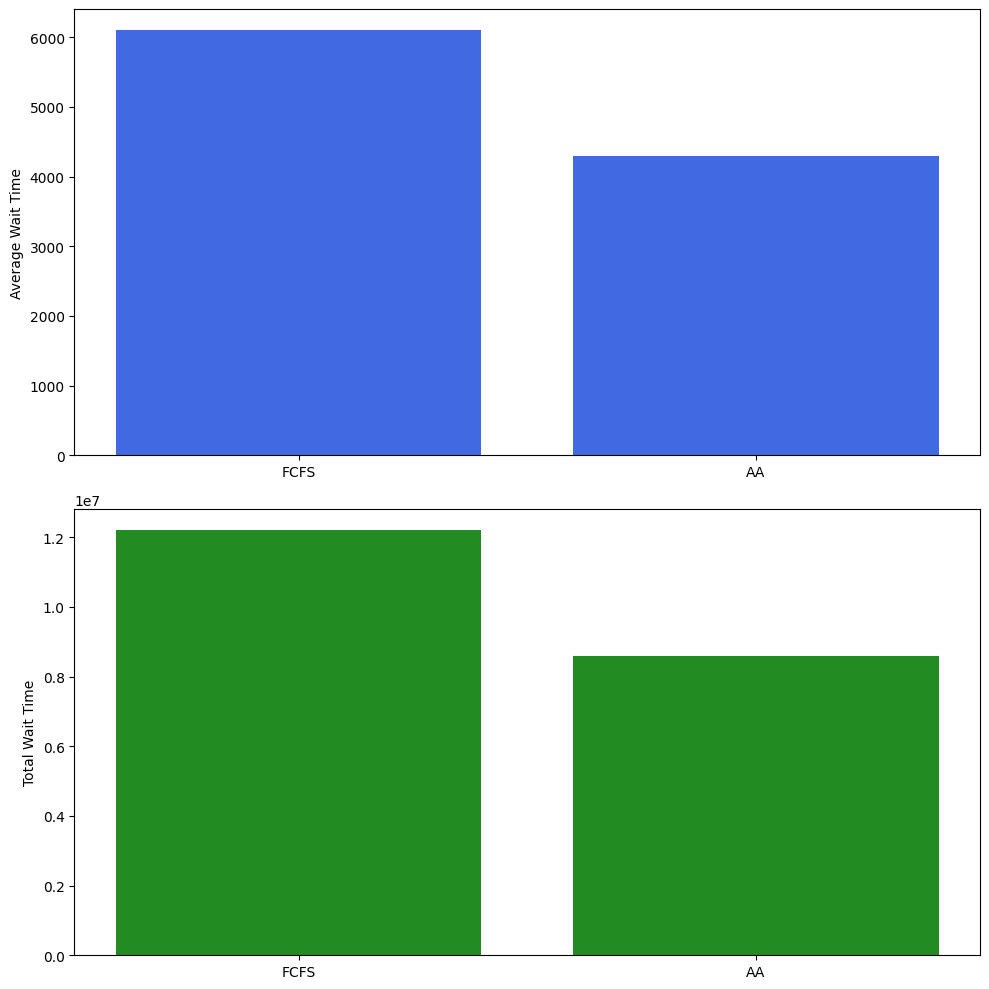

In [5]:
mean_minutes_acuity_1 = patients[patients['Acuity_Lvl'] == 1]['OccupancyTime'].dt.minute.mean()
mean_minutes_acuity_2 = patients[patients['Acuity_Lvl'] == 2]['OccupancyTime'].dt.minute.mean()

def scheduler(df, criterion="ArrivalTime", BATCH_SIZE=20, NBeds=10):
    NBeds = NBeds
    BATCH_SIZE = BATCH_SIZE
    print("Scheduling acc:", criterion)
    org = df.copy()
    if "Age" in criterion or "Acuity_Lvl" in criterion:
        queue = df.sort_values(by=criterion[:-1], ascending=False).iloc[:NBeds].copy()   
    
    queue = df.sort_values(by=criterion).iloc[:NBeds].copy()
    df = df.iloc[NBeds:]

    print("Queue length:", queue.shape[0])
    print("Batch Size:", BATCH_SIZE)

    wait_times = [0 for i in range(NBeds)]
    penalty_1, penalty_2 = 0, 0

    for start in range(0, len(patients), BATCH_SIZE):
        end = min(start + BATCH_SIZE, len(patients))
        batch = df[start:end].copy()
        if "Age" in criterion or "Acuity_Lvl" in criterion:
            batch = batch.sort_values(criterion[:-1], ascending=False)
        batch = batch.sort_values(criterion)
        while not batch.empty:
            entry_patient = batch.iloc[0]
            arrival_time = entry_patient["ArrivalTime"]
            acuity_level = entry_patient["Acuity_Lvl"]
            
            wait_time = acuity_weights[acuity_level] * (abs(arrival_time - queue.iloc[0]["OccupancyTime"])).total_seconds() / 60
            if wait_time > (60 + mean_minutes_acuity_1) and acuity_level == 1: # Add occupancy avg time for the acuity lvl
                penalty_1 += 1
            elif wait_time > (180 + mean_minutes_acuity_2) and acuity_level == 2:
                penalty_2 += 1
            wait_times.append(wait_time)
            
            queue = queue.iloc[1:].copy()  # Remove the front patient from the queue
            queue = pd.concat([queue, entry_patient.to_frame().T], ignore_index=True, sort=False)
            batch = batch.iloc[1:].copy()  # Remove the processed patient from the batch
    org['wait_times'] = wait_times
    Percent_penalty_1 = abs(penalty_1 - len(patients[patients['Acuity_Lvl'] == 1]))/100
    Percent_penalty_2 = abs(penalty_2 - len(patients[patients['Acuity_Lvl'] == 2]))/100

    return np.mean(wait_times), np.sum(wait_times), np.max(wait_times), np.min(wait_times), df, Percent_penalty_1, Percent_penalty_2
avg_fcfs, total_fcfs, maximum_fcfs, minimum_fcfs, fcfs_df, per_penalty1_fcfs, per_penalty2_fcfs = scheduler(patients, "ArrivalTime", BATCH_SIZE=30, NBeds=15)
print("Average Wait Time:", avg_fcfs)
# print("Sum Wait Time:", total_fcfs)
# print("Maximum Wait Time:", maximum_fcfs)
# print("Minimum Wait Time:", minimum_fcfs)

print("----"*20)
avg_aat, total_aat, maximum_aat, minimum_aat, df_aat, per_penalty1_aat, per_penalty2_aat = scheduler(patients, ["Acuity_Lvl", "ArrivalTime"], BATCH_SIZE=30, NBeds=15)
print("Average Wait Time:", avg_aat)
# print("Sum Wait Time:", total_aat)
# print("Maximum Wait Time:", maximum_aat)
# print("Minimum Wait Time:", minimum_aat)

# print("----"*20)
# avg_aaat, total_aaat, maximum_aaat, minimum_aaat, df_aaat, per_penalty1_aaat, per_penalty2_aaat = scheduler(patients, ["Acuity_Lvl", "Age", "ArrivalTime"], BATCH_SIZE=30, NBeds=15)
# print("Average Wait Time:", avg_aaat)
# print("Sum Wait Time:", total_aaat)
# print("Maximum Wait Time:", maximum_aaat)
# print("Minimum Wait Time:", minimum_aaat)


import pandas as pd

# Create DataFrames for each scheduling method with penalties
data_fcfs = {
    "Method": "FCFS",
    "Weighted Avg Waiting Time": avg_fcfs,
    # "Total Wait Time": total_fcfs,
    # "Maximum Wait Time": maximum_fcfs,
    # "Minimum Wait Time": minimum_fcfs,
    # "Penalty 1": per_penalty1_fcfs,
    # "Penalty 2": per_penalty2_fcfs,
    "Penalty": (per_penalty1_fcfs+per_penalty2_fcfs)/2
}

data_aat = {
    "Method": "AA",
    "Weighted Avg Waiting Time": avg_aat,
    # "Total Wait Time": total_aat,
    # "Maximum Wait Time": maximum_aat,
    # "Minimum Wait Time": minimum_aat,
    # "Penalty 1": per_penalty1_aat,
    # "Penalty 2": per_penalty2_aat,
    "Penalty": (per_penalty1_aat+per_penalty2_aat)/2
}

# data_aaat = {
#     "Method": "Acuity + Age + ArrivalTime",
#     "Average Wait Time": avg_aaat,
#     "Total Wait Time": total_aaat,
#     "Maximum Wait Time": maximum_aaat,
#     "Minimum Wait Time": minimum_aaat,
#     "Penalty 1": per_penalty1_aaat,
#     "Penalty 2": per_penalty2_aaat,
# }

df_fcfs = pd.DataFrame(data_fcfs, index=[0])
df_aat = pd.DataFrame(data_aat, index=[0])
# df_aaat = pd.DataFrame(data_aaat, index=[0])

# Concatenate the DataFrames
result_df = pd.concat([df_fcfs, df_aat], ignore_index=True)

methods = ["FCFS", "AA"]
average_wait_times = [avg_fcfs, avg_aat]
total_wait_times = [total_fcfs, total_aat]
maximum_wait_times = [maximum_fcfs, maximum_aat]
minimum_wait_times = [minimum_fcfs, minimum_aat]

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Create comparison plots
ax1.bar(methods, average_wait_times, color='royalblue')
ax1.set_ylabel('Average Wait Time')

ax2.bar(methods, total_wait_times, color='forestgreen')
ax2.set_ylabel('Total Wait Time')

# Save or show the plots
plt.tight_layout()
plt.show()

In [6]:
result_df

,Method,Weighted Avg Waiting Time,Penalty
0,FCFS,6100.206835,0.04
1,AA,4301.285275,0.20


In [7]:
from sklearn.preprocessing import LabelEncoder

for col in ["Gender"]:
    patients[col] = LabelEncoder().fit_transform(patients[col])

data = patients.drop(["ArrivalTime", "OccupancyTime"], axis=1)
data_cols = data.columns
data = torch.tensor(data.to_numpy(), dtype=torch.float32)

#### Handling Unboundedness using U (Size) thresholding

In [8]:
U = int(data.shape[0] * 0.6)
S_in = data[:U]
S_out = data[U:-1]
X_test = data[-1]

# Deep Q Learning model

### Agent

# Pretraining model inference

In [9]:
patients[patients.ArrivalTime == patients.ArrivalTime.min()]
patients

,ArrivalTime,Acuity_Lvl,Age,Gender,year,month,day,hour,minute,second,OccupancyTime
0,2023-01-09 16:55:48,1,81,0,2023,1,9,16,55,48,2023-01-09 17:25:48
1,2023-01-10 10:35:07,3,100,1,2023,1,10,10,35,7,2023-01-10 13:35:07
2,2023-01-01 01:58:11,2,46,1,2023,1,1,1,58,11,2023-01-01 03:28:11
3,2023-01-09 02:18:40,2,31,1,2023,1,9,2,18,40,2023-01-09 03:48:40
4,2023-01-09 23:01:22,3,22,1,2023,1,9,23,1,22,2023-01-10 02:01:22
...,...,...,...,...,...,...,...,...,...,...,...
1995,2023-01-09 03:04:58,1,82,0,2023,1,9,3,4,58,2023-01-09 03:34:58
1996,2023-01-02 11:35:38,2,46,1,2023,1,2,11,35,38,2023-01-02 13:05:38
1997,2023-01-06 13:02:11,4,34,1,2023,1,6,13,2,11,2023-01-06 18:02:11
1998,2023-01-07 21:21:08,3,20,0,2023,1,7,21,21,8,2023-01-08 00:21:08


### Deep Reinforcement Learning module

In [10]:
random.randrange(0, 1)

0

In [2]:
import os
os.listdir()

['.git',
 '.ipynb_checkpoints',
 '.vscode',
 '2021-ed-pivot-table.xlsm',
 'AAT vs FCFS.png',
 'battery.html',
 'ChatGPT prompts.txt',
 'Deep Learning in Medical Image Analysis and Multimodal Learning for Clinical Decision Support.pdf',
 'dummy_doctor_data.csv',
 'dummy_patient_data.csv',
 'Edlight_ML_task.ipynb',
 'ER Efficiency using patients relationship.pdf',
 'Hospital triage and patient history',
 'Improving ED using RL.ipynb',
 'Improving ED using RL.pdf',
 'P2P Scheduling.pdf',
 'patient_scheduling_rl_dataset_dummy.csv',
 'Reinforcement Learning for Optimal Control of Queueing Systems.pdf',
 'RL.py',
 'SIM-PFED_A_Simulation-Based_Decision_Making_Model_of_Patient_Flow_for_Improving_Patient_Throughput_Time_in_Emergency_Department.pdf',
 'Solving unbounded state space problem in ED - RL based approach.pdf',
 'Solving unbounded state space problem using RL.pptx',
 'Steps for the PDGRL algorithm.docx']

In [14]:
import random
import numpy as np
import torch
from tqdm import trange
import torch.nn as nn
import torch.optim as optim
import gym

from tqdm.autonotebook import tqdm

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, action_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.network(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, gamma=0.99, learning_rate=0.001):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.HuberLoss()

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def train(self, state, action, next_state, reward, done):
        q_values = self.q_network(state.to(device))
        next_q_values = self.target_network(next_state.to(device))
        target = q_values.clone()
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.gamma * next_q_values.max().item()

        loss = self.loss_fn(q_values, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


class PatientSchedulingEnv(gym.Env):
    def __init__(self, dataset):
        super(PatientSchedulingEnv, self).__init__()
        self.dataset = dataset
        self.state_dim = dataset.shape[0] - 1  # Exclude the 'Action' column
        self.action_dim = 2
        self.current_index = 0

    def reset(self):
        self.current_index = 0
        return self.get_state()

    def step(self, action):
        if action not in [0, 1]:
            raise ValueError("Invalid action")

        next_state = self.get_state()
        reward = self.calculate_reward(action)
        done = self.current_index >= len(self.dataset) - 1
        info = {}

        self.current_index += 1

        return next_state, reward, done, info

    def get_state(self):
        return self.dataset[self.current_index, :-1]  # Exclude the 'Action' column

    def calculate_reward(self, action):
        acuity_level = self.dataset[self.current_index, 0]
        age = self.dataset[self.current_index, 1]
        gender = self.dataset[self.current_index, 2]
        if action == 0: # Modifications needed
            reward = (acuity_level * 0.8 + age * 0.15 + gender * 0.05)
        else:
            reward = (-acuity_level * 0.8 + age * 0.15 + gender * 0.05)

        return reward

state_dim = S_in.shape[1] - 1
action_dim = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
agent = DQNAgent(state_dim, action_dim)
env = PatientSchedulingEnv(S_in )
num_episodes = 10
rewards = []

Episodes: 100%|██████████| 10/10 [00:44<00:00,  4.47s/it, TotalReward=1.13e+4]


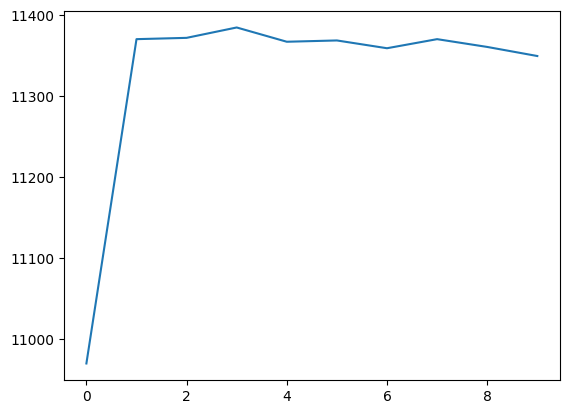

In [15]:

with trange(num_episodes, desc='Episodes', position=0, leave=True) as progress_bar:
    for episode in progress_bar:
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = state.unsqueeze(0).clone().detach()
            action = agent.select_action(state_tensor.to(device))
            next_state, reward, done, _ = env.step(action)
            agent.train(state_tensor, action, next_state.clone().detach().unsqueeze(0), reward, done)
            state = next_state
            total_reward += reward

        agent.update_target_network()

        rewards.append(total_reward)
        progress_bar.set_postfix(TotalReward=total_reward.item())

plt.plot(rewards)
plt.show()

In [17]:
min(rewards), max(rewards)

(tensor(10970.3936), tensor(11384.7969))

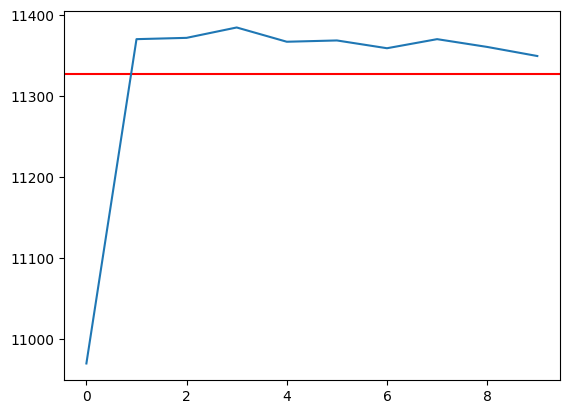

In [18]:
# Checking the last 300 rewards
plt.axhline(np.mean(rewards), color='r', linestyle='-')
plt.plot(rewards[-300:]);